In [1]:
from pyEDM import *
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona
import rasterio.mask
from descartes import PolygonPatch
from rasterio.plot import show
from tqdm import tqdm
import datetime
import random
from sklearn.preprocessing import StandardScaler
import scipy.stats

In [11]:
SM_EA = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/FLDAS_SM/EA/'
SM_Anomaly = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/FLDAS_SM/EA_Anomaly/'

In [2]:
def generate_dekads(start, end):
    '''
    Generates list of timestamps of dekads between two dates
    
    Parameters
    ----------
    start : pd.datetime object
        Start date of list
    end : pd.datetime object
        end date of list
    '''
    
    dtrange = pd.date_range(start, end)
    days = list(range(len(dtrange))) #length of dtrange
    daysDF = pd.DataFrame({'Days': days}, index=dtrange)
    d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
    dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
    dekads = daysDF.groupby(dekaddates).mean()
    dekads = dekads.index
    
    return dekads

In [3]:
start = pd.datetime(2002,7,1)
end = pd.datetime(2019,4,30)

dekads = generate_dekads(start, end)

In [5]:
def stack_rasters(in_dir, keyword):
    
    '''
    This function creates a raster stack xarray DataArray given a specified variable keyword.
    Keywords = 'precip', 'ndvi','lst'
    
    '''
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains('.tif')
    files = files[tifs]
    
    stacked = []
    
    for filename in tqdm(files): 
        if keyword in filename:
    
            file = xr.open_rasterio(in_dir+filename)
            stacked.append(file.sel(band=1))
            
    combined = xr.concat(stacked, dim = 'time')
  

    return combined.assign_coords(time=dekads)

In [9]:
#stack_out = stack_rasters(precip_dir, 'chirps')

stack_out = stack_rasters(SM_EA, 'SM')

100%|██████████| 606/606 [00:06<00:00, 95.15it/s] 


In [10]:

#all other variables
ds_anom = stack_out.groupby('time.month') - stack_out.groupby("time.month").mean("time")

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [14]:
def dataarray2tiff(dataarray, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D xarray DataArray into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile
        
    for i in np.arange(0,len(os.listdir(in_dir))):
        data = np.array(dataarray[i])
       
        with rasterio.open(out_dir + out_name + str(np.array(dataarray[i].time))[:10] + '.tif', 'w', **profile) as dst:
            
            data = data.astype(np.float32)
            dst.write(data, indexes = 1)

In [13]:
dataarray2tiff(ds_anom, SM_EA, SM_Anomaly, 'anom_ea_SM_')

In [ ]:
def pixelwise_ts_table(in_dir, keyword):
    
    '''
    This function searches through the file directory and creates a dataframe of pixel values over time from rasters
    based on a given keyword describing the environmental variable of interest to generate a raster time series stack 
    
   In the output dataframe, columns are each pixel extracted from the raster (read squentially into a list)
   and rows are the same pixel over time (dekads going down)
    
    Args:
    - in_dir: path to the input directory
    -keyword: string that is unique to the environmental variable
        options: ['chirps', 'lst', 'ndvi', 'pet', 'SM', 'Tmax']
    '''
    
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains(keyword)
    files = files[tifs]
    #n_samples = len(files)
    
    
    pixelwise_TS = []
    
    for filename in tqdm(files): 
        
        
            open_file = xr.open_rasterio(in_dir+filename).sel(band=1)
            array = open_file.values
            #print(array)
            scaler = StandardScaler()
            scaled = scaler.fit_transform(array)
            # Determine the size of the datatable
            #rs_cols, rs_rows = array.shape()

    #         rs_cols = array.shape[0]
    #         rs_rows = array.shape[1]

            pixel_list = array.ravel().tolist()
            
            pixelwise_TS.append(pixel_list)

            # Create a DataFrame from the pixelwise list:
           # table = pd.DataFrame(pixelwise_TS)

            # Add rs_cols and rs_rows as attributes to the table DataFrame
    #         table.rs_cols = rs_cols
    #         table.rs_rows = rs_rows
    #         table.n_samples = n_samples
    #         if label:
    #             table.label = label
    return pd.DataFrame(pixelwise_TS)

    

In [ ]:
sm_table = pixelwise_ts_table(SM_Anomaly, 'SM')


In [20]:
sm_table.label = 'sm'
sm_table.rs_rows = 674
sm_table.rs_cols = 583
sm_table.n_samples = 606

In [28]:
def pixelwise_simplex(table, target_label, train, test, ed, pi):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given a table of pixel values across time for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: input table, where every column is the time series of each pixel in a raster
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    - rs_cols: number of columns to reshape list into original raster size
   
     '''

    simplex_out_df = []
    table_dict = {'Time': dekads }
    #table_dict = {
       # 'Time': list(range(0,table.n_samples)) 
    #}    
    simplex_out_df = []
    label = table.label # Assumes that all tables have labels
    dekads_fut = generate_dekads(dekads[-1],pd.datetime(2020,4,30))
    
    for col in tqdm(range(len(table.columns))):
        [table_dict.update({table.label: table.iloc[:,col]})]
        interim_df = pd.DataFrame(table_dict)
        interim_df.set_index('Time',inplace=True, drop=False)
        
        
#         if interim_df.isnull().values.any():
        if max([len(interim_df[interim_df[col].isnull()]) for col in interim_df.columns]) > 20:
            simplex_out_df.append(np.nan)  
            #simplex_out_df.append(np.nan)
        else:
            # Check whether column has a few nans
            if interim_df[label].isnull().values.any():
                # If so, iterate through nan rows and replace with monthly mean
                for t in interim_df[interim_df[label].isnull()].index:
                    interim_df[label].loc[t] = interim_df[label][interim_df.index.month == t.month].mean()
                    
            #interim_df = pd.DataFrame({'Time': list(range(0,table.n_samples)), 'Data': table[column]}) #'Time': dekads
            simplex_result = Simplex(dataFrame = interim_df, 
                                     lib = train,
                                     pred = test,
                                     E = ed, Tp = pi, 
                                     columns = target_label, target = target_label, showPlot = False)
            
            # Add datetime index + fix dekad values for future values
            simplex_result.Time = pd.to_datetime(simplex_result.Time)
            simplex_result.set_index(simplex_result.Time, inplace=True)
            
            
            # Fix datetime index for future dekads
            simplex_result[-pi:].Time = dekads_fut[1:pi+1]
            
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            
            rho = list(error.values())[2]
            simplex_out_df.append(rho) 
            
    return(np.reshape(simplex_out_df, (table.rs_rows, table.rs_cols)))
            



In [30]:
sm_ea_simplex_ed6 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 18)

100%|██████████| 392942/392942 [1:06:02<00:00, 99.16it/s] 


In [ ]:
sm_ea_simplex_ed6_pi1 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 1)
sm_ea_simplex_ed6_pi2 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 2)
sm_ea_simplex_ed6_pi3 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 3)
sm_ea_simplex_ed6_pi4 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 4)
sm_ea_simplex_ed6_pi5 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 5)
sm_ea_simplex_ed6_pi6 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 6)
sm_ea_simplex_ed6_pi7 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 7)
sm_ea_simplex_ed6_pi8 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 8)
sm_ea_simplex_ed6_pi9 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 9)
sm_ea_simplex_ed6_pi10 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 10)
sm_ea_simplex_ed6_pi11 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 11)
sm_ea_simplex_ed6_pi12 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 12)
sm_ea_simplex_ed6_pi13 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 13)
sm_ea_simplex_ed6_pi14 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 14)
sm_ea_simplex_ed6_pi15 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 15)
sm_ea_simplex_ed6_pi16 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 16)
sm_ea_simplex_ed6_pi17 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 17)

 90%|████████▉ | 353458/392942 [1:06:41<08:49, 74.54it/s] 

In [44]:
sm_ea_simplex_ed6_pi18 = pixelwise_simplex(sm_table, 'sm', '1 303', '304 606', ed = 6, pi = 18)

100%|██████████| 392942/392942 [1:04:16<00:00, 101.89it/s]


In [41]:
sm = '/home/rgreen/DroughtEDM/Data/Prediction_skill_interval/sm/'

In [36]:
def array2tiff(array, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D array into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile

    with rasterio.open(out_dir + out_name + '.tif', 'w', **profile) as dst:
        data = array
        data = data.astype(np.float32)
        #data[data<=0] = np.nan
        dst.write(data, indexes=1)


In [40]:
array2tiff(sm_ea_simplex_ed6, SM_Anomaly, sm, 'sm_ea_simplex_ed6')

In [46]:
array2tiff(sm_ea_simplex_ed6_pi1, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi01')
array2tiff(sm_ea_simplex_ed6_pi2, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi02')
array2tiff(sm_ea_simplex_ed6_pi3, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi03')
array2tiff(sm_ea_simplex_ed6_pi4, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi04')
array2tiff(sm_ea_simplex_ed6_pi5, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi05')
array2tiff(sm_ea_simplex_ed6_pi6, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi06')
array2tiff(sm_ea_simplex_ed6_pi7, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi07')
array2tiff(sm_ea_simplex_ed6_pi8, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi08')
array2tiff(sm_ea_simplex_ed6_pi9, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi09')
array2tiff(sm_ea_simplex_ed6_pi10, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi10')
array2tiff(sm_ea_simplex_ed6_pi11, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi11')
array2tiff(sm_ea_simplex_ed6_pi12, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi12')
array2tiff(sm_ea_simplex_ed6_pi13, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi13')
array2tiff(sm_ea_simplex_ed6_pi14, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi14')
array2tiff(sm_ea_simplex_ed6_pi15, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi15')
array2tiff(sm_ea_simplex_ed6_pi16, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi16')
array2tiff(sm_ea_simplex_ed6_pi17, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi17')
array2tiff(sm_ea_simplex_ed6_pi18, SM_Anomaly, sm, 'sm_ea_simplex_ed6_pi18')


In [51]:
def simplex_mean(in_dir):
    
    
    simplex_rasters = np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(simplex_rasters).str.contains('.tif')
    files = simplex_rasters[tifs]
    
    mean_simplex = []
    
    for filename in files:
            simplex_raster = rasterio.open(in_dir + filename)
            read_raster = simplex_raster.read(1)
            mean_raster = np.nanmean(read_raster)
            mean_simplex.append(mean_raster)
            
    return mean_simplex

In [52]:
psi_sm = simplex_mean(sm)

In [54]:
psi_df = pd.DataFrame({'Prediction_Interval': list(range(1,19)), 'Prediction_skill': psi_sm})

In [55]:
psi_df

,Prediction_Interval,Prediction_skill
0,1,0.380791
1,2,0.265090
2,3,0.231191
3,4,0.162356
4,5,0.160742
5,6,0.142112
6,7,0.127076
7,8,0.123567
8,9,0.107894
9,10,0.107747


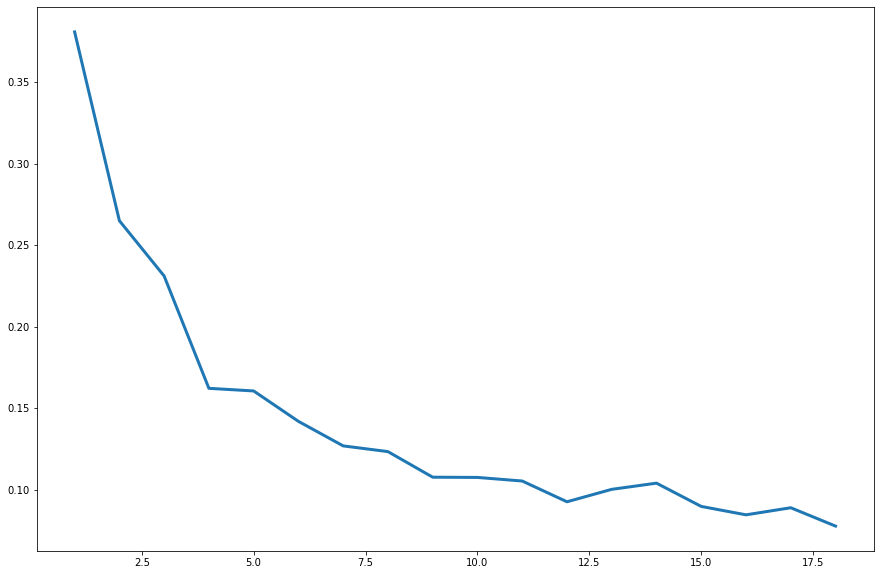

In [56]:
fig = plt.figure(figsize = (15, 10))
plt.plot(psi_df.Prediction_Interval, psi_df.Prediction_skill, linewidth = 3)